# Pytorch workflow

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu124'

## 1. Data (Preparing and loading)

Dữ liệu tồn tại dưới nhiều dạng như bảng, ảnh, video, ...

Mô hình học máy đòi hỏi dữ liệu này cần được đưa về dạng số học để đưa vào mô hình

### Tạo dữ liệu thử nghiệm

Giả sử có một tập dữ liệu cho trước (Ở đây dữ liệu sẽ được tạo bằng cách sử dụng một hàm tuyến tính)

In [2]:
start = 0
end = 100
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = 0.5 * X + 0.5

X, y

(tensor([[0.0000e+00],
         [2.0000e-02],
         [4.0000e-02],
         ...,
         [9.9940e+01],
         [9.9960e+01],
         [9.9980e+01]]),
 tensor([[ 0.5000],
         [ 0.5100],
         [ 0.5200],
         ...,
         [50.4700],
         [50.4800],
         [50.4900]]))

### Chia dữ liệu thành tập train và tập test

Trong thực tế, dữ liệu thường được tổng hợp thành một tập duy nhất. Để quá trình huấn luyện hiệu quả thường chúng ta sẽ chia tập dữ liệu thành 2 tập bao gồm 1 tập huấn luyện và 1 tập kiểm thử. Tập huấn luyện thậm trí còn được chia ra thành 2 tập nữa là tập huấn luyện chính và tập kiểm tra. Tập kiểm tra này sẽ được sử dụng để đánh giá mô hình xuyên suốt quá trình huấn luyện còn tập kiểm thử sẽ được sử dụng để đánh giá xem mô hình có thực sự đủ tốt hay chưa.

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

Để hiểu rõ hơn về dữ liệu, một bước quan trọng trong quá trình xử lý dữ liệu là visualize dữ liệu này

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=1, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=1, label="Testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    plt.legend(prop={"size": 14})
    plt.xlabel("Input Features")
    plt.ylabel("Target")
    plt.show()


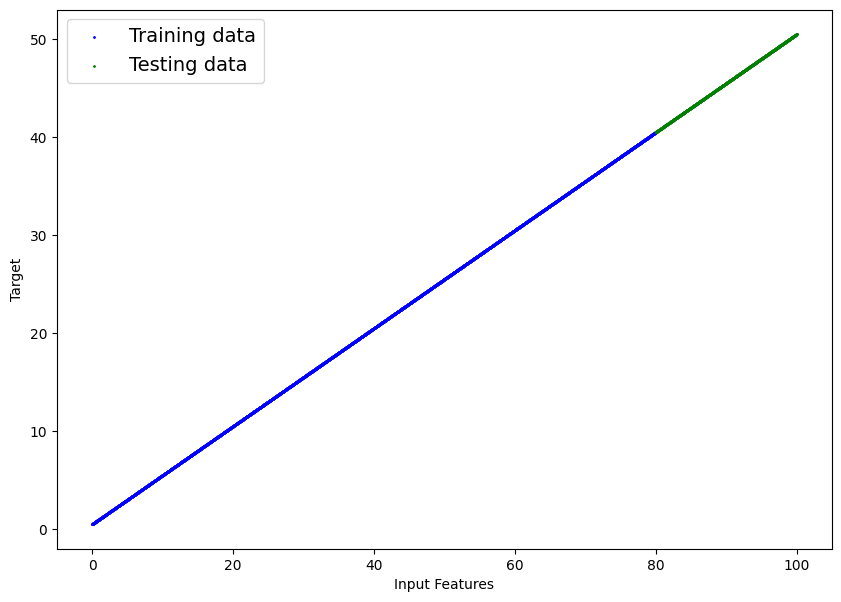

In [5]:
plot_predictions()

## 2. Building Pytorch model

Ở bước này chúng ta sẽ xây dựng một mô hình hồi quy tuyến tính đơn giản để huấn luyện trên dữ liệu trên

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

Một số thành phần quan trọng trong một mô hình pytorch
* torch.nn - chứa tất cả các thành phần quan trọng để tạo ra một mạng neural
* torch.nn.Parameter - tham số mà mô hình sẽ thực hiện việc học
* torch.nn.Module - class nền tảng cho tất cả loại mạng neural, khi xây dựng một mạng neural bất kì chỉ cần kế thừa lại class này và viết lại hàm init và forward
* torch.optim - các optimizers trong pytorch sử dụng để tối ưu hóa các tham số trong mô hình
* def forward() - một hàm bắt buộc phải có trong một mạng Neural, chịu trách nhiệm biểu diễn tất cả những tính toán trong quá trình suy diễn tiến.

Tham khảo: https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking Pytorch model

In [7]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## 3. Training

### Predicting before training

Trước khi huấn luyện, hãy thử kiểm tra mô hình khởi tạo

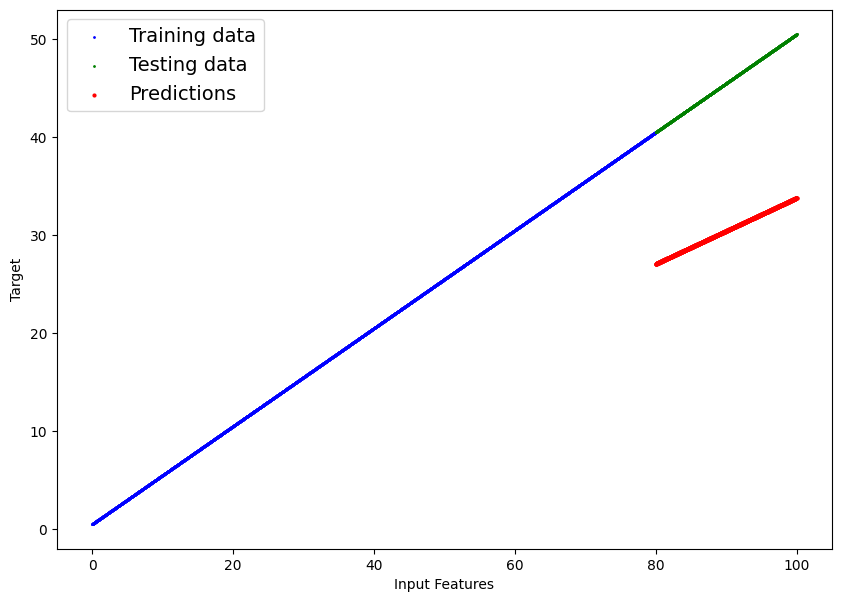

In [9]:
with torch.inference_mode(): # Có thể sử dụng torch.no_grad() với tác dụng tương đương nhưng inference mode sẽ nhanh hơn
    y_preds = model_0(X_test)
plot_predictions(predictions=y_preds)

### Training

Mục đich của quá trình này là đánh giá và điểu chỉnh lại các tham số của mô hình sao cho nó biểu diễn dữ liệu chính xác hơn.

- Đâu tiên chúng ta cần một cách để đánh giá xem hiệu suất của mô hình so với kết quả lý tưởng, để làm được điều này chúng ta sử dụng một hàm loss. Pytorch cung cấp một danh sách các hàm loss được xây dựng sẵn trong thư viện như sau: https://pytorch.org/docs/stable/nn.html#loss-functions

- Tiếp theo chúng ta cần một optimizer, Optimizers đóng vai trò như một thuật toán giúp xác định cách điều chỉnh tham số mô hình một cách tối ưu nhất dựa trên các chỉ số đánh giá của hàm loss. Tham khảo: https://pytorch.org/docs/stable/optim.html#

- Sau đó chúng ta cần tạo một vòng lặp huấn luyện và vòng lặp kiểm thử cho quá trình huấn luyện

In [10]:
# Loss function
loss_fn = nn.L1Loss()

# Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001)

Một số thứ cần trong một vòng lặp huấn luyện:
- Lặp qua dữ liệu
- Dữ liệu được đưa qua hàm forward() để đưa ra dự đoán -> Suy diễn tiến
- Tính toán loss dựa trên kết quả suy diễn tiến
- Optimizer zero grad
- Di chuyển ngược lại mô hình để tính toán các gradient dựa trên loss
- Optimizer step: sử dụng optimizer để tối ưu mô hình và cải thiện loss

In [11]:
torch.manual_seed(42)

epochs = 1000

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model_0.train()

    # Suy diễn tiến
    y_pred = model_0(X_train)

    # Tính toán loss
    loss = loss_fn(y_pred, y_train)

    # optimizer zero grad
    optimizer.zero_grad()

    # Backprogation
    loss.backward()

    # Optimizer step
    optimizer.step()

    model_0.eval()

    # test loop
    with torch.inference_mode():
      test_pred = model_0(X_test)
      test_loss = loss_fn(test_pred, y_test.type(torch.float))
      if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 6.901943206787109 | MAE Test Loss: 11.46772289276123 
Epoch: 100 | MAE Train Loss: 0.5794740915298462 | MAE Test Loss: 2.741469621658325 
Epoch: 200 | MAE Train Loss: 0.20826219022274017 | MAE Test Loss: 3.563121795654297 
Epoch: 300 | MAE Train Loss: 0.2928867042064667 | MAE Test Loss: 3.359246015548706 
Epoch: 400 | MAE Train Loss: 0.5766518115997314 | MAE Test Loss: 2.707432746887207 
Epoch: 500 | MAE Train Loss: 0.1415071189403534 | MAE Test Loss: 2.1304471492767334 
Epoch: 600 | MAE Train Loss: 0.27769896388053894 | MAE Test Loss: 3.355454444885254 
Epoch: 700 | MAE Train Loss: 0.153889998793602 | MAE Test Loss: 3.622676372528076 
Epoch: 800 | MAE Train Loss: 0.27789175510406494 | MAE Test Loss: 3.3318533897399902 
Epoch: 900 | MAE Train Loss: 0.6705825328826904 | MAE Test Loss: 2.4374046325683594 


In [12]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.4991])), ('bias', tensor([0.2314]))])

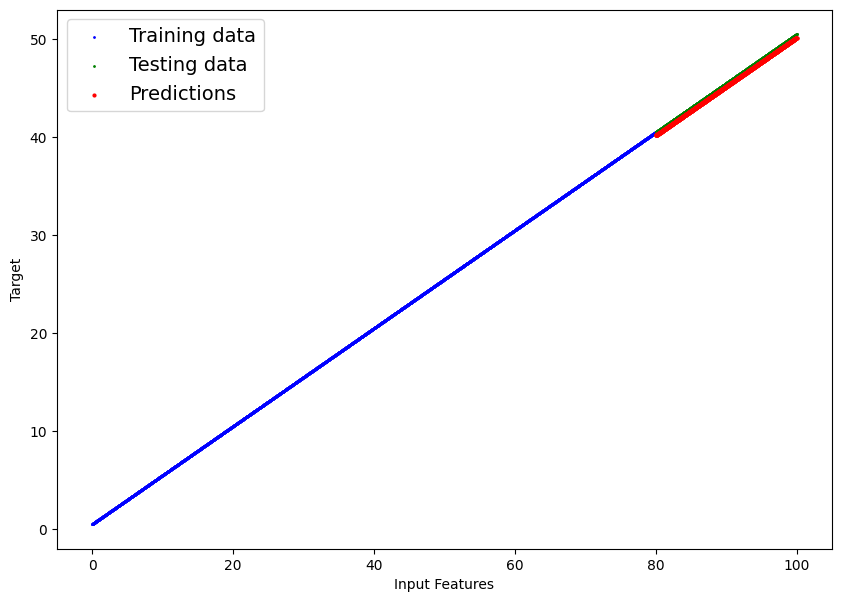

In [13]:
with torch.inference_mode(): # Có thể sử dụng torch.no_grad() với tác dụng tương đương nhưng inference mode sẽ nhanh hơn
    y_preds = model_0(X_test)
plot_predictions(predictions=y_preds)

Text(0, 0.5, 'Loss')

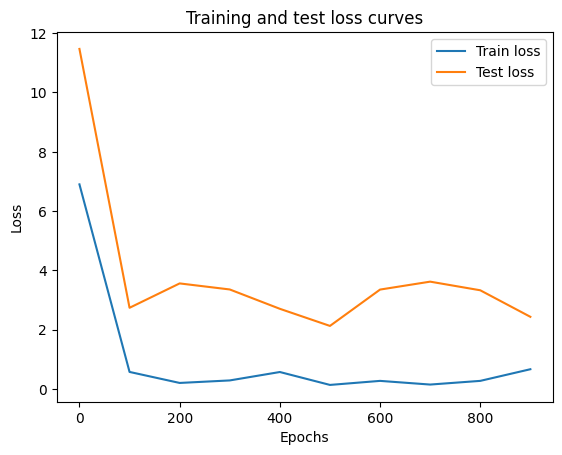

In [14]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Loss")

## 4. Save and Load model

Có 3 phương thức cần biết trong việc lưu và load mô hình:
- Sử dụng torch.save(): lưu mô hình pytorch dưới dạng pickle
- Sử dụng torch.load(): load một mô hình vào code
- torch.nn.Module.load_state_dict():

Tham khảo: https://pytorch.org/tutorials/beginner/saving_loading_models.html

### Save model

In [16]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "LinearRegressionModel_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/LinearRegressionModel_0.pth')

In [17]:
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

### Loading model

In [18]:
model_1 = LinearRegressionModel()
model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-18-7d8d9a09e94a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [19]:
model_1.state_dict()

OrderedDict([('weights', tensor([0.4991])), ('bias', tensor([0.2314]))])